# **RAVIR Challenge**         

**Axel Romero**       
*Deep Learning for Medical Image Analysis Course*

1. Data      
    1.1. Data augmentation    
2. SegRAVIR Model     
3. SegRAVIRAttention Model        
4. Results     
5. Conclusions       


GitHub repository of this practical exercise with all the code: https://github.com/Axelrom16/RAVIR_Project 

In [1]:
from source.data import RAVIRDataset
from source.segravir import SegRAVIRModel, Loss_Dice_CE_l2, SegRAVIRAttentionModel
from source.utils import plot_figure_mask, plot_figure_mask_prediction, evaluation_jaccard_dice, evaluate_model

import os
import wandb
import torch
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torchview import draw_graph
from torch.utils.data.sampler import SubsetRandomSampler

/media/axelrom16/HDD/AI/RAVIR_Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 2
EPOCHS = 100
LR = 1e-3

## **Data**

In order to use the RAVIR dataset we defined a Dataset class called `RAVIRDataset` with the following parameters: 
* `data_root`: path to the images     
* `segmentation_root`: path to the segmentation masks. If it is None we are using the test data.     
* `size`: size of the images     
* `interpolation`: interporlation used if resize is needed    
* `n_labels`: number of different labels in the segmentation masks    



Then, we define a dataloader with the train and test datasets with a batch size of 8.     

In [3]:
train_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=768,
    interpolation="bicubic",
    n_labels=3,
    augmentation=False
)

test_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/test',
    segmentation_root=None,
    size=768,
    interpolation="bicubic",
    n_labels=3,
    augmentation=False
)

Now, we can analyse the train and test datasets to see the amount of available data. We can see that the amount of data for training is very small, so we have to perform some data augmentation technique to increse the data. 

In [4]:
print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))

Number of training samples:  23
Number of testing samples:  19


Example of training image and its corresponding mask. 

torch.Size([768, 768, 3])
tensor(0.) tensor(1.)
torch.Size([768, 768, 1])
tensor(0, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


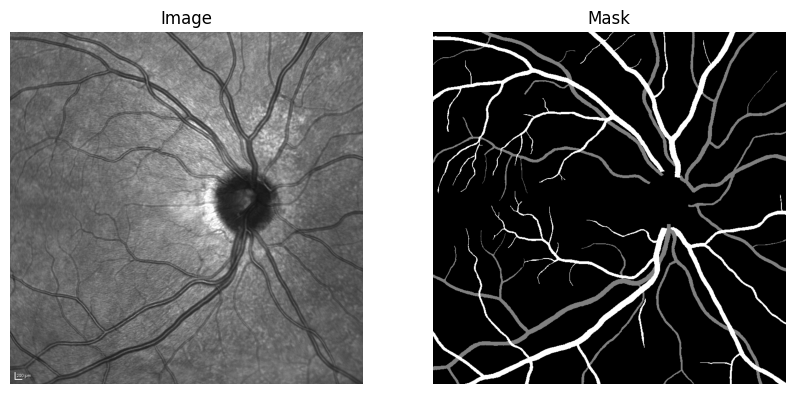

In [5]:
ex = train_data[0]
print(ex['image'].shape)
print(ex['image'].min(), ex['image'].max())
print(ex['mask'].shape)
print(ex['mask'].min(), ex['mask'].max())

plot_figure_mask(ex['image'], ex['mask'])

Example of test image. 

torch.Size([768, 768, 3])
tensor(0.) tensor(1.)


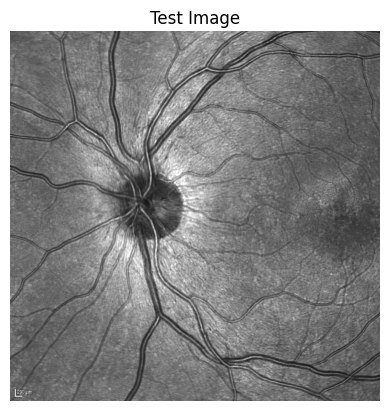

In [6]:
ex_test = test_data[0]
print(ex_test['image'].shape)
print(ex_test['image'].min(), ex_test['image'].max())

plt.imshow(ex_test['image'])
plt.title('Test Image')
plt.axis('off')
plt.show()

### Data Augmentation

For the data augmentation process, we decided to perform, for each image, the following transformations: 
* Horizontal flip    
* Vertical flip     
* Rotation     
* Color jitter    
* Crop    
* Affine transformation    
* Perspective    
* Grayscale      
* Erase      

The implementation of the data augmentation process is in the `data_augmentation.py` script. Now, we can define the dataset with the augmented data and analyze the effect of the different transformations. 

In [4]:
train_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=768,
    interpolation="bicubic",
    n_labels=3,
    augmentation=True
)

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.1 * dataset_size))
np.random.seed(16)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print("Number of training samples: ", len(train_dataloader)*BATCH_SIZE)
print("Number of validation samples: ", len(val_dataloader)*BATCH_SIZE)
print("Number of testing samples: ", len(test_dataloader)*BATCH_SIZE)

Number of training samples:  22
Number of validation samples:  2
Number of testing samples:  20


torch.Size([2, 768, 768, 3])
tensor(0.) tensor(1.)
torch.Size([2, 768, 768, 1])
tensor(0, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


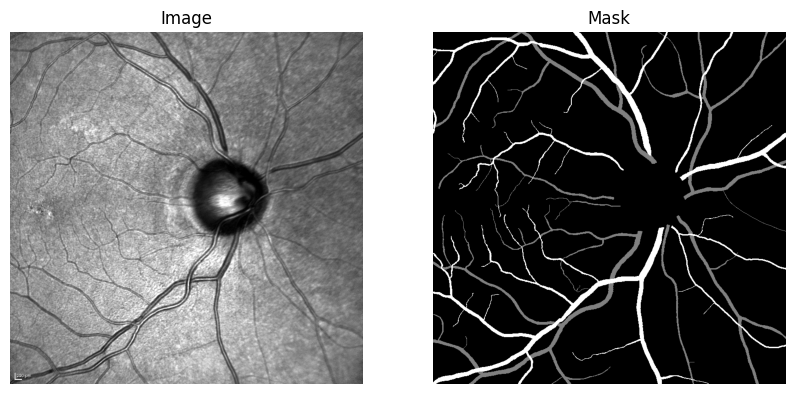

In [9]:
ex = next(iter(train_dataloader))
image = ex['image'].numpy()
mask = ex['mask'].numpy()

print(ex['image'].shape)
print(ex['image'].min(), ex['image'].max())
print(ex['mask'].shape)
print(ex['mask'].min(), ex['mask'].max())

plot_figure_mask(image[0], mask[0])

In [10]:
print("Images shape: ", image.shape)
print("Masks shape: ", mask.shape)

Images shape:  (2, 768, 768, 3)
Masks shape:  (2, 768, 768, 1)


## **SegRAVIR Model**

In [11]:
model = SegRAVIRModel()

print(model)

SegRAVIRModel(
  (encoder): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (residual_layer): Identity()
    )
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ResidualBlock(
      (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(32, eps=1e-

In [12]:
model_graph = draw_graph(model, input_size=(1,3,768,768), expand_nested=False)
model_graph.visual_graph.render('materials/SegRAVIR_graph', view=False)

'materials/SegRAVIR_graph.pdf'

In [13]:
print(summary(model, (3, 768, 768)))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 16, 768, 768]        448
|    └─ResidualBlock: 2-2                [-1, 16, 768, 768]        --
|    |    └─Conv2d: 3-1                  [-1, 16, 768, 768]        2,320
|    |    └─BatchNorm2d: 3-2             [-1, 16, 768, 768]        32
|    |    └─Dropout: 3-3                 [-1, 16, 768, 768]        --
|    |    └─Conv2d: 3-4                  [-1, 16, 768, 768]        2,320
|    |    └─BatchNorm2d: 3-5             [-1, 16, 768, 768]        32
|    |    └─Dropout: 3-6                 [-1, 16, 768, 768]        --
|    |    └─Identity: 3-7                [-1, 16, 768, 768]        --
|    └─Conv2d: 2-3                       [-1, 32, 384, 384]        4,640
|    └─ResidualBlock: 2-4                [-1, 32, 384, 384]        --
|    |    └─Conv2d: 3-8                  [-1, 32, 384, 384]        9,248
| 

In [14]:
loss_dice = smp.losses.DiceLoss(
    mode='multiclass',
    classes=[0, 1, 2]
)
loss_dice = Loss_Dice_CE_l2(
    weight_dice=1.0,
    weight_ce=1.0,
    weight_l2=0.001
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [15]:
output_dir = '/media/axelrom16/HDD/AI/RAVIR_Project/model'
os.makedirs(output_dir, exist_ok=True)

wandb.login()

# Initialize wandb
wandb.init(project='SegRAVIR',
           config={
            "batch_size": BATCH_SIZE,
            "learning_rate": LR,
            "dataset": "RAVIR",
        })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: romeroaxel16. Use `wandb login --relogin` to force relogin


In [16]:
wandb.run

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.cuda()
    model.train()
    running_loss = 0.0

    # Initialize tqdm with a dynamic description
    tqdm_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True, dynamic_ncols=True)

    for example in tqdm_iterator:
        image = example['image'].permute(0, 3, 1, 2).cuda()
        mask = example['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda().long()

        # Forward pass
        pred_mask, pred_img = model(image)
        loss = loss_dice(pred_mask, pred_img, mask, image)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Log loss to wandb
        wandb.log({"loss": loss.item(), "learning_rate": optimizer.param_groups[0]["lr"]})

    # Step the learning rate scheduler at the end of each epoch
    lr_scheduler.step()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}') 

    # Validation loop
    if epoch % 10 == 0:
        model.eval()
        for example_val in val_dataloader:
            image = example_val['image'].permute(0, 3, 1, 2).cuda()
            mask = example_val['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda().long()
            pred_mask, pred_img = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)[:, 0, ...]

            # Jaccard Index and Dice Coefficient
            jaccard_score, dice_score = evaluation_jaccard_dice(pred_mask.cpu(), mask.cpu())
            print(f'Jaccard Index: {jaccard_score}', f'Dice Coefficient: {dice_score}')


# Save the trained model if needed
torch.save(model.state_dict(), os.path.join(output_dir, 'trained_model.pth'))

Epoch 1/100: 100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


Epoch [1/100], Loss: 1.7257
Jaccard Index: 0.2910566031932831 Dice Coefficient: 0.31076371669769287


Epoch 2/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch [2/100], Loss: 1.6024


Epoch 3/100: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


Epoch [3/100], Loss: 1.5494


Epoch 4/100: 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]


Epoch [4/100], Loss: 1.5112


Epoch 5/100: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch [5/100], Loss: 1.4812


Epoch 6/100: 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]


Epoch [6/100], Loss: 1.4585


Epoch 7/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch [7/100], Loss: 1.4269


Epoch 8/100: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]


Epoch [8/100], Loss: 1.4012


Epoch 9/100: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


Epoch [9/100], Loss: 1.3889


Epoch 10/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch [10/100], Loss: 1.3832


Epoch 11/100: 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


Epoch [11/100], Loss: 1.3676
Jaccard Index: 0.5226739645004272 Dice Coefficient: 0.6445114016532898


Epoch 12/100: 100%|██████████| 11/11 [00:03<00:00,  3.42it/s]


Epoch [12/100], Loss: 1.3573


Epoch 13/100: 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [13/100], Loss: 1.3465


Epoch 14/100: 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]


Epoch [14/100], Loss: 1.3311


Epoch 15/100: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch [15/100], Loss: 1.3217


Epoch 16/100: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch [16/100], Loss: 1.3169


Epoch 17/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch [17/100], Loss: 1.3067


Epoch 18/100: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch [18/100], Loss: 1.3067


Epoch 19/100: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch [19/100], Loss: 1.3010


Epoch 20/100: 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epoch [20/100], Loss: 1.2890


Epoch 21/100: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


Epoch [21/100], Loss: 1.2899
Jaccard Index: 0.5479797124862671 Dice Coefficient: 0.6704612374305725


Epoch 22/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch [22/100], Loss: 1.2863


Epoch 23/100: 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


Epoch [23/100], Loss: 1.2796


Epoch 24/100: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch [24/100], Loss: 1.2786


Epoch 25/100: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


Epoch [25/100], Loss: 1.2755


Epoch 26/100: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Epoch [26/100], Loss: 1.2761


Epoch 27/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch [27/100], Loss: 1.2747


Epoch 28/100: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch [28/100], Loss: 1.2674


Epoch 29/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch [29/100], Loss: 1.2653


Epoch 30/100: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]


Epoch [30/100], Loss: 1.2659


Epoch 31/100: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Epoch [31/100], Loss: 1.2583
Jaccard Index: 0.5910707712173462 Dice Coefficient: 0.7130568027496338


Epoch 32/100: 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [32/100], Loss: 1.2630


Epoch 33/100: 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


Epoch [33/100], Loss: 1.2607


Epoch 34/100: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


Epoch [34/100], Loss: 1.2639


Epoch 35/100: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [35/100], Loss: 1.2532


Epoch 36/100: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Epoch [36/100], Loss: 1.2552


Epoch 37/100: 100%|██████████| 11/11 [00:03<00:00,  3.06it/s]


Epoch [37/100], Loss: 1.2525


Epoch 38/100: 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [38/100], Loss: 1.2565


Epoch 39/100: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]


Epoch [39/100], Loss: 1.2538


Epoch 40/100: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch [40/100], Loss: 1.2554


Epoch 41/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [41/100], Loss: 1.2580
Jaccard Index: 0.5295023322105408 Dice Coefficient: 0.6449424028396606


Epoch 42/100: 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]


Epoch [42/100], Loss: 1.2591


Epoch 43/100: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


Epoch [43/100], Loss: 1.2527


Epoch 44/100: 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]


Epoch [44/100], Loss: 1.2561


Epoch 45/100: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Epoch [45/100], Loss: 1.2443


Epoch 46/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch [46/100], Loss: 1.2467


Epoch 47/100: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


Epoch [47/100], Loss: 1.2490


Epoch 48/100: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


Epoch [48/100], Loss: 1.2407


Epoch 49/100: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch [49/100], Loss: 1.2463


Epoch 50/100: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


Epoch [50/100], Loss: 1.2477


Epoch 51/100: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch [51/100], Loss: 1.2435
Jaccard Index: 0.5616071820259094 Dice Coefficient: 0.6817783117294312


Epoch 52/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch [52/100], Loss: 1.2379


Epoch 53/100: 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]


Epoch [53/100], Loss: 1.2389


Epoch 54/100: 100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


Epoch [54/100], Loss: 1.2352


Epoch 55/100: 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [55/100], Loss: 1.2325


Epoch 56/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch [56/100], Loss: 1.2337


Epoch 57/100: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


Epoch [57/100], Loss: 1.2310


Epoch 58/100: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch [58/100], Loss: 1.2305


Epoch 59/100: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


Epoch [59/100], Loss: 1.2333


Epoch 60/100: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


Epoch [60/100], Loss: 1.2283


Epoch 61/100: 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epoch [61/100], Loss: 1.2286
Jaccard Index: 0.6176037788391113 Dice Coefficient: 0.7392418384552002


Epoch 62/100: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


Epoch [62/100], Loss: 1.2316


Epoch 63/100: 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epoch [63/100], Loss: 1.2257


Epoch 64/100: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


Epoch [64/100], Loss: 1.2265


Epoch 65/100: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Epoch [65/100], Loss: 1.2278


Epoch 66/100: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]


Epoch [66/100], Loss: 1.2266


Epoch 67/100: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


Epoch [67/100], Loss: 1.2316


Epoch 68/100: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]


Epoch [68/100], Loss: 1.2272


Epoch 69/100: 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


Epoch [69/100], Loss: 1.2351


Epoch 70/100: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


Epoch [70/100], Loss: 1.2274


Epoch 71/100: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]


Epoch [71/100], Loss: 1.2242
Jaccard Index: 0.6222425103187561 Dice Coefficient: 0.7431784272193909


Epoch 72/100: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


Epoch [72/100], Loss: 1.2270


Epoch 73/100: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


Epoch [73/100], Loss: 1.2265


Epoch 74/100: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]


Epoch [74/100], Loss: 1.2299


Epoch 75/100: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]


Epoch [75/100], Loss: 1.2240


Epoch 76/100: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch [76/100], Loss: 1.2280


Epoch 77/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch [77/100], Loss: 1.2276


Epoch 78/100: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch [78/100], Loss: 1.2246


Epoch 79/100: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Epoch [79/100], Loss: 1.2228


Epoch 80/100: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


Epoch [80/100], Loss: 1.2276


Epoch 81/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch [81/100], Loss: 1.2251
Jaccard Index: 0.6240200996398926 Dice Coefficient: 0.7442119121551514


Epoch 82/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch [82/100], Loss: 1.2278


Epoch 83/100: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch [83/100], Loss: 1.2250


Epoch 84/100: 100%|██████████| 11/11 [00:04<00:00,  2.46it/s]


Epoch [84/100], Loss: 1.2229


Epoch 85/100: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


Epoch [85/100], Loss: 1.2255


Epoch 86/100: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch [86/100], Loss: 1.2212


Epoch 87/100: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch [87/100], Loss: 1.2210


Epoch 88/100: 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


Epoch [88/100], Loss: 1.2270


Epoch 89/100: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]


Epoch [89/100], Loss: 1.2263


Epoch 90/100: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch [90/100], Loss: 1.2244


Epoch 91/100: 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]


Epoch [91/100], Loss: 1.2229
Jaccard Index: 0.6244006156921387 Dice Coefficient: 0.7458010315895081


Epoch 92/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch [92/100], Loss: 1.2215


Epoch 93/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch [93/100], Loss: 1.2232


Epoch 94/100: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch [94/100], Loss: 1.2248


Epoch 95/100: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


Epoch [95/100], Loss: 1.2184


Epoch 96/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch [96/100], Loss: 1.2187


Epoch 97/100: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]


Epoch [97/100], Loss: 1.2208


Epoch 98/100: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch [98/100], Loss: 1.2252


Epoch 99/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch [99/100], Loss: 1.2239


Epoch 100/100: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


Epoch [100/100], Loss: 1.2230


torch.Size([2, 1, 768, 768])
tensor(0, device='cuda:0') tensor(2, device='cuda:0')


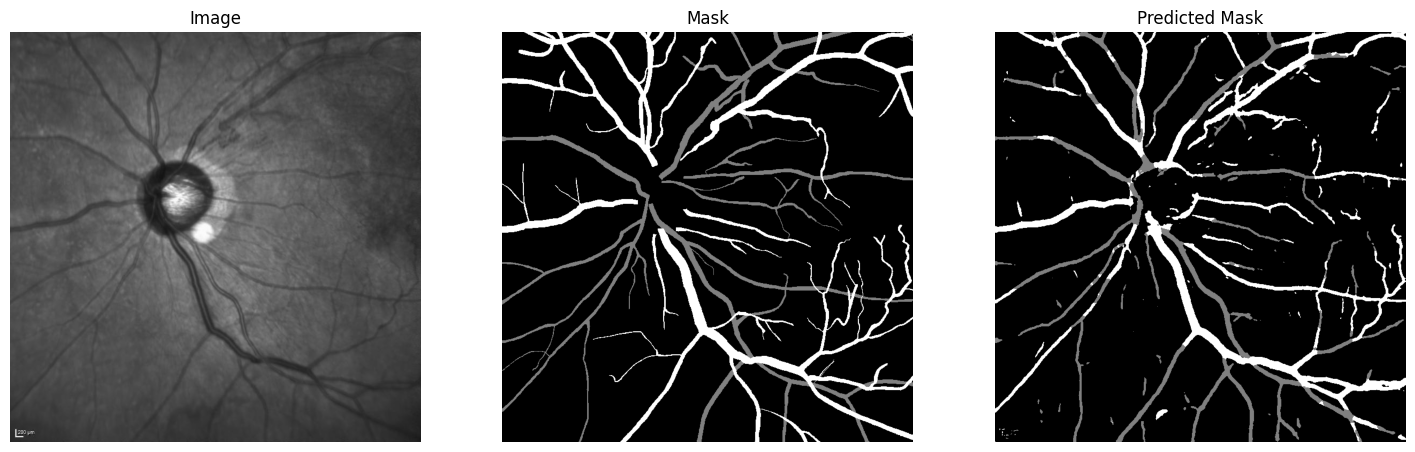

In [17]:
pred_mask, pred_img = model(example_val['image'].permute(0, 3, 1, 2).cuda())
pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
print(pred_mask.shape)
print(pred_mask.min(), pred_mask.max())

plot_figure_mask_prediction(example_val['image'][0, ...], example_val['mask'][0, ...], pred_mask[0, ...].permute(1, 2, 0).cpu().detach().numpy(), figsize=(18, 10))

## **SegRAVIRAttention Model**

In [5]:
model_attn = SegRAVIRAttentionModel()

print(model_attn)

SegRAVIRAttentionModel(
  (encoder): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (residual_layer): Identity()
    )
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ResidualBlock(
      (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(32

In [6]:
model_graph_attn = draw_graph(model_attn, input_size=(1,3,768,768), expand_nested=False)
model_graph_attn.visual_graph.render('materials/SegRAVIRAttention_graph', view=False)

'materials/SegRAVIRAttention_graph.pdf'

In [7]:
print(summary(model_attn, (3, 768, 768)))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 16, 768, 768]        448
|    └─ResidualBlock: 2-2                [-1, 16, 768, 768]        --
|    |    └─Conv2d: 3-1                  [-1, 16, 768, 768]        2,320
|    |    └─BatchNorm2d: 3-2             [-1, 16, 768, 768]        32
|    |    └─Dropout: 3-3                 [-1, 16, 768, 768]        --
|    |    └─Conv2d: 3-4                  [-1, 16, 768, 768]        2,320
|    |    └─BatchNorm2d: 3-5             [-1, 16, 768, 768]        32
|    |    └─Dropout: 3-6                 [-1, 16, 768, 768]        --
|    |    └─Identity: 3-7                [-1, 16, 768, 768]        --
|    └─Conv2d: 2-3                       [-1, 32, 384, 384]        4,640
|    └─ResidualBlock: 2-4                [-1, 32, 384, 384]        --
|    |    └─Conv2d: 3-8                  [-1, 32, 384, 384]        9,248
| 

In [8]:
loss_dice = smp.losses.DiceLoss(
    mode='multiclass',
    classes=[0, 1, 2]
)
loss_dice = Loss_Dice_CE_l2(
    weight_dice=1.0,
    weight_ce=1.0,
    weight_l2=0.001
)
optimizer = torch.optim.Adam(model_attn.parameters(), lr=LR)

In [9]:
output_dir = '/media/axelrom16/HDD/AI/RAVIR_Project/model'
os.makedirs(output_dir, exist_ok=True)

wandb.login()

# Initialize wandb
wandb.init(project='SegRAVIRAttention',
           config={
            "batch_size": BATCH_SIZE,
            "learning_rate": LR,
            "dataset": "RAVIR",
        })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: romeroaxel16. Use `wandb login --relogin` to force relogin


In [10]:
wandb.run

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model_attn.cuda()
    model_attn.train()
    running_loss = 0.0

    # Initialize tqdm with a dynamic description
    tqdm_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True, dynamic_ncols=True)

    for example in tqdm_iterator:
        image = example['image'].permute(0, 3, 1, 2).cuda()
        mask = example['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda().long()

        # Forward pass
        pred_mask, pred_img = model_attn(image)
        loss = loss_dice(pred_mask, pred_img, mask, image)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Log loss to wandb
        wandb.log({"loss": loss.item(), "learning_rate": optimizer.param_groups[0]["lr"]})

    # Step the learning rate scheduler at the end of each epoch
    lr_scheduler.step()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}') 

    # Validation loop
    if epoch % 10 == 0:
        model_attn.eval()
        for example_val in val_dataloader:
            image = example_val['image'].permute(0, 3, 1, 2).cuda()
            mask = example_val['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda().long()
            pred_mask, pred_img = model_attn(image)
            pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)[:, 0, ...]

            # Jaccard Index and Dice Coefficient
            jaccard_score, dice_score = evaluation_jaccard_dice(pred_mask.cpu(), mask.cpu())
            print(f'Jaccard Index: {jaccard_score}', f'Dice Coefficient: {dice_score}')


# Save the trained model if needed
torch.save(model_attn.state_dict(), os.path.join(output_dir, 'trained_model_attention.pth'))

Epoch 1/100: 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


Epoch [1/100], Loss: 1.8526
Jaccard Index: 0.29154178500175476 Dice Coefficient: 0.3110400438308716


Epoch 2/100: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch [2/100], Loss: 1.8032


Epoch 3/100: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Epoch [3/100], Loss: 1.7549


Epoch 4/100: 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Epoch [4/100], Loss: 1.6941


Epoch 5/100: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Epoch [5/100], Loss: 1.6149


Epoch 6/100: 100%|██████████| 11/11 [00:07<00:00,  1.50it/s]


Epoch [6/100], Loss: 1.5506


Epoch 7/100: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


Epoch [7/100], Loss: 1.5015


Epoch 8/100: 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Epoch [8/100], Loss: 1.4681


Epoch 9/100: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


Epoch [9/100], Loss: 1.4426


Epoch 10/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [10/100], Loss: 1.4190


Epoch 11/100: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


Epoch [11/100], Loss: 1.3986
Jaccard Index: 0.4353756606578827 Dice Coefficient: 0.535457968711853


Epoch 12/100: 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Epoch [12/100], Loss: 1.3818


Epoch 13/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [13/100], Loss: 1.3655


Epoch 14/100: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


Epoch [14/100], Loss: 1.3567


Epoch 15/100: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Epoch [15/100], Loss: 1.3562


Epoch 16/100: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


Epoch [16/100], Loss: 1.3400


Epoch 17/100: 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Epoch [17/100], Loss: 1.3311


Epoch 18/100: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Epoch [18/100], Loss: 1.3230


Epoch 19/100: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Epoch [19/100], Loss: 1.3151


Epoch 20/100: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Epoch [20/100], Loss: 1.3152


Epoch 21/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [21/100], Loss: 1.3102
Jaccard Index: 0.5005843639373779 Dice Coefficient: 0.6133836507797241


Epoch 22/100: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch [22/100], Loss: 1.3049


Epoch 23/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [23/100], Loss: 1.2975


Epoch 24/100: 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


Epoch [24/100], Loss: 1.2885


Epoch 25/100: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


Epoch [25/100], Loss: 1.2895


Epoch 26/100: 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


Epoch [26/100], Loss: 1.2967


Epoch 27/100: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Epoch [27/100], Loss: 1.2856


Epoch 28/100: 100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


Epoch [28/100], Loss: 1.2790


Epoch 29/100: 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


Epoch [29/100], Loss: 1.2794


Epoch 30/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [30/100], Loss: 1.2734


Epoch 31/100: 100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


Epoch [31/100], Loss: 1.2740
Jaccard Index: 0.5700515508651733 Dice Coefficient: 0.694086492061615


Epoch 32/100: 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


Epoch [32/100], Loss: 1.2690


Epoch 33/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [33/100], Loss: 1.2638


Epoch 34/100: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Epoch [34/100], Loss: 1.2585


Epoch 35/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [35/100], Loss: 1.2603


Epoch 36/100: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


Epoch [36/100], Loss: 1.2688


Epoch 37/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [37/100], Loss: 1.2583


Epoch 38/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [38/100], Loss: 1.2625


Epoch 39/100: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [39/100], Loss: 1.2602


Epoch 40/100: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch [40/100], Loss: 1.2617


Epoch 41/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [41/100], Loss: 1.2554
Jaccard Index: 0.5301426649093628 Dice Coefficient: 0.6484803557395935


Epoch 42/100: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch [42/100], Loss: 1.2584


Epoch 43/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [43/100], Loss: 1.2517


Epoch 44/100: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Epoch [44/100], Loss: 1.2490


Epoch 45/100: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Epoch [45/100], Loss: 1.2515


Epoch 46/100: 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Epoch [46/100], Loss: 1.2472


Epoch 47/100: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Epoch [47/100], Loss: 1.2567


Epoch 48/100: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Epoch [48/100], Loss: 1.2433


Epoch 49/100: 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Epoch [49/100], Loss: 1.2437


Epoch 50/100: 100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


Epoch [50/100], Loss: 1.2417


Epoch 51/100: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Epoch [51/100], Loss: 1.2415
Jaccard Index: 0.5936969518661499 Dice Coefficient: 0.7168206572532654


Epoch 52/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [52/100], Loss: 1.2346


Epoch 53/100: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


Epoch [53/100], Loss: 1.2317


Epoch 54/100: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [54/100], Loss: 1.2332


Epoch 55/100: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Epoch [55/100], Loss: 1.2316


Epoch 56/100: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch [56/100], Loss: 1.2288


Epoch 57/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [57/100], Loss: 1.2392


Epoch 58/100: 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


Epoch [58/100], Loss: 1.2398


Epoch 59/100: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch [59/100], Loss: 1.2278


Epoch 60/100: 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Epoch [60/100], Loss: 1.2319


Epoch 61/100: 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Epoch [61/100], Loss: 1.2278
Jaccard Index: 0.6311540603637695 Dice Coefficient: 0.7520318031311035


Epoch 62/100: 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


Epoch [62/100], Loss: 1.2312


Epoch 63/100: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Epoch [63/100], Loss: 1.2315


Epoch 64/100: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Epoch [64/100], Loss: 1.2236


Epoch 65/100: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Epoch [65/100], Loss: 1.2230


Epoch 66/100: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Epoch [66/100], Loss: 1.2264


Epoch 67/100: 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]


Epoch [67/100], Loss: 1.2283


Epoch 68/100: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Epoch [68/100], Loss: 1.2313


Epoch 69/100: 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Epoch [69/100], Loss: 1.2215


Epoch 70/100: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


Epoch [70/100], Loss: 1.2253


Epoch 71/100: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


Epoch [71/100], Loss: 1.2297
Jaccard Index: 0.6260213255882263 Dice Coefficient: 0.7476344108581543


Epoch 72/100: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


Epoch [72/100], Loss: 1.2261


Epoch 73/100: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Epoch [73/100], Loss: 1.2226


Epoch 74/100: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch [74/100], Loss: 1.2238


Epoch 75/100: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [75/100], Loss: 1.2287


Epoch 76/100: 100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


Epoch [76/100], Loss: 1.2298


Epoch 77/100: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


Epoch [77/100], Loss: 1.2295


Epoch 78/100: 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Epoch [78/100], Loss: 1.2331


Epoch 79/100: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


Epoch [79/100], Loss: 1.2288


Epoch 80/100: 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Epoch [80/100], Loss: 1.2235


Epoch 81/100: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Epoch [81/100], Loss: 1.2269
Jaccard Index: 0.6038281321525574 Dice Coefficient: 0.7270482778549194


Epoch 82/100: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


Epoch [82/100], Loss: 1.2228


Epoch 83/100: 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Epoch [83/100], Loss: 1.2238


Epoch 84/100: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Epoch [84/100], Loss: 1.2191


Epoch 85/100: 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Epoch [85/100], Loss: 1.2219


Epoch 86/100: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Epoch [86/100], Loss: 1.2244


Epoch 87/100: 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


Epoch [87/100], Loss: 1.2237


Epoch 88/100: 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Epoch [88/100], Loss: 1.2213


Epoch 89/100: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Epoch [89/100], Loss: 1.2215


Epoch 90/100: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


Epoch [90/100], Loss: 1.2182


Epoch 91/100: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


Epoch [91/100], Loss: 1.2214
Jaccard Index: 0.6360205411911011 Dice Coefficient: 0.7567542195320129


Epoch 92/100: 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


Epoch [92/100], Loss: 1.2268


Epoch 93/100: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [93/100], Loss: 1.2188


Epoch 94/100: 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Epoch [94/100], Loss: 1.2244


Epoch 95/100: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


Epoch [95/100], Loss: 1.2254


Epoch 96/100: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


Epoch [96/100], Loss: 1.2226


Epoch 97/100: 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Epoch [97/100], Loss: 1.2275


Epoch 98/100: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


Epoch [98/100], Loss: 1.2234


Epoch 99/100: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


Epoch [99/100], Loss: 1.2181


Epoch 100/100: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

Epoch [100/100], Loss: 1.2213


torch.Size([2, 1, 768, 768])
tensor(0, device='cuda:0') tensor(2, device='cuda:0')


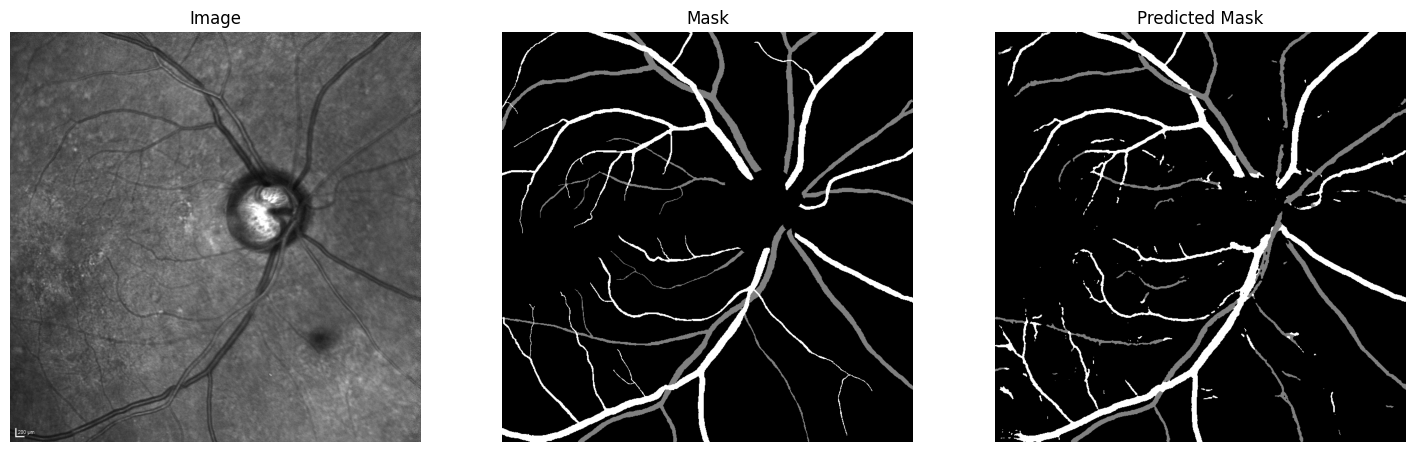

In [11]:
pred_mask, pred_img = model_attn(example_val['image'].permute(0, 3, 1, 2).cuda())
pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
print(pred_mask.shape)
print(pred_mask.min(), pred_mask.max())

plot_figure_mask_prediction(example_val['image'][0, ...], example_val['mask'][0, ...], pred_mask[0, ...].permute(1, 2, 0).cpu().detach().numpy(), figsize=(18, 10))